# Single Image Super Resolution with LapSRN

This is an implementation of LapSRN using Tensorflow.  
LapSRN is a single image super resolution algorithm proposed in https://arxiv.org/pdf/1704.03915.pdf.  


There are several differences between my implementation and the original paper:
1. I use 64x64 sub-images with stride 48, instead of 128x128.
2. The learning rate is constant and the same for all layers in my model.  
3. I use DIV2K dataset for training.  
4. I did not use the mentioned initialization methods for the filters.  
5. I did not use data augmentation.

In [55]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from custom_image_dataset_from_directory import image_dataset_from_directory
import matplotlib.pyplot as plt
import os
from PIL import Image
import utils

In [56]:
upscale_factor = 4
batch_size = 32

# Size for the training images
lr_image_size = (64,64) 
hr_image_size = (lr_image_size[0] * upscale_factor, lr_image_size[1] * upscale_factor)

# Stride for the cropping images
lr_stride = (lr_image_size[0] * 3 // 4, lr_image_size[1] * 3 // 4) 
hr_stride = (lr_stride[0] * upscale_factor, lr_stride[1] * upscale_factor)

model_dir = 'models'

# 1. Data Preprocessing

DIV2K is used for training.  
Set5, Set14, B100, Urban100, Manga109 can be used for testing.

Training images are cropped into square sub images of train_image_size using the custom image_dataset_from_directory() function.  
Note that ```image_dataset_from_directory()``` is modified from the tensorflow source code (https://github.com/keras-team/keras/blob/v2.7.0/keras/preprocessing/image_dataset.py#L30-L227) for generating the dataset with cropping rather than the default ```smart_resize()```. Set crop_to_aspect_ratio=True if you want to use the ```smart_resize()```.

In [57]:
# Load the DIV2K dataset
train_lr_dir = 'data/DIV2K/train/LRx4_bicubic'
train_hr_dir = 'data/DIV2K/train/HR'

train_lr_images = image_dataset_from_directory(train_lr_dir, image_size=lr_image_size, stride=lr_stride, batch_size=None, shuffle=False)
train_hr_images = image_dataset_from_directory(train_hr_dir, image_size=hr_image_size, stride=hr_stride,
                                               batch_size=None, shuffle=False)
# Validation dataset
val_lr_dir = 'data/DIV2K/validation/LRx4_bicubic'
val_hr_dir = 'data/DIV2K/validation/HR'

val_lr_images = image_dataset_from_directory(val_lr_dir, image_size=lr_image_size, stride=lr_stride,
                                             batch_size=None, shuffle=False)
val_hr_images = image_dataset_from_directory(val_hr_dir, image_size=hr_image_size, stride=hr_stride,
                                             batch_size=None, shuffle=False)


Only run the the block below for debug / if you really want to know the number of sub-images created.  
It takes 2 minutes for the DIV2K dataset, which has 800 images

In [58]:
# def num_elements_in_dataset(ds):
#     num_elements = 0
#     it = iter(ds)
#     for batch in it:
#         num_elements += batch.shape[0]
#     return num_elements

# print("Number of sub-images in LR training set:", num_elements_in_dataset(train_lr_images))
# print("Number of sub-images in HR training set:", num_elements_in_dataset(train_hr_images))
# print("Number of sub-images in LR validation set:", num_elements_in_dataset(val_lr_images))
# print("Number of sub-images in HR validation set:", num_elements_in_dataset(val_hr_images))

In [59]:
# Normalize the images
normalize = layers.Rescaling(1./255)
train_lr_images = train_lr_images.map(lambda batch: normalize(batch))
train_hr_images = train_hr_images.map(lambda batch: normalize(batch))
val_lr_images = val_lr_images.map(lambda batch: normalize(batch))
val_hr_images = val_hr_images.map(lambda batch: normalize(batch))

# Set shapes to [1, hr_image_size[0], hr_image_size[1], num_channels] for using bicubic downscale
def set_shape(batch, batch_size, image_size, num_channels):
    batch.set_shape([batch_size, image_size[0], image_size[1], num_channels])
    return batch

train_hr_images = train_hr_images.map(lambda batch: tf.reshape(batch, [1, hr_image_size[0], hr_image_size[1], 3]))
val_hr_images = val_hr_images.map(lambda batch: tf.reshape(batch, [1, hr_image_size[0], hr_image_size[1], 3]))
train_hr_images = train_hr_images.map(lambda batch: set_shape(batch, batch_size=1, image_size=hr_image_size, num_channels=3))
val_hr_images = val_hr_images.map(lambda batch: set_shape(batch, batch_size=1, image_size=hr_image_size, num_channels=3))
train_hr_images = train_hr_images.map(lambda batch: tf.reshape(batch, [hr_image_size[0], hr_image_size[1], 3]))
val_hr_images = val_hr_images.map(lambda batch: tf.reshape(batch, [hr_image_size[0], hr_image_size[1], 3]))

# Downscale hr images to 2x for computing loss in 2x layers
bicubic_downscale = layers.Resizing(lr_image_size[0] * 2, lr_image_size[1] * 2, interpolation="bicubic")
train_2x_images = train_hr_images.map(lambda batch: bicubic_downscale(batch))
val_2x_images = val_hr_images.map(lambda batch: bicubic_downscale(batch))


# Produce the (input, target) dataset for training
train_ds = tf.data.Dataset.zip((train_lr_images, {'2x': train_2x_images, '4x': train_hr_images}))
val_ds = tf.data.Dataset.zip((val_lr_images, {'2x': val_2x_images, '4x': val_hr_images}))

# Batch
train_ds = train_ds.shuffle(batch_size*16, reshuffle_each_iteration=True)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE).batch(batch_size, drop_remainder=True)
val_ds = val_ds.shuffle(batch_size*16, reshuffle_each_iteration=True)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE).batch(batch_size, drop_remainder=True)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(64, 64, 3) (128, 128, 3) (256, 256, 3)


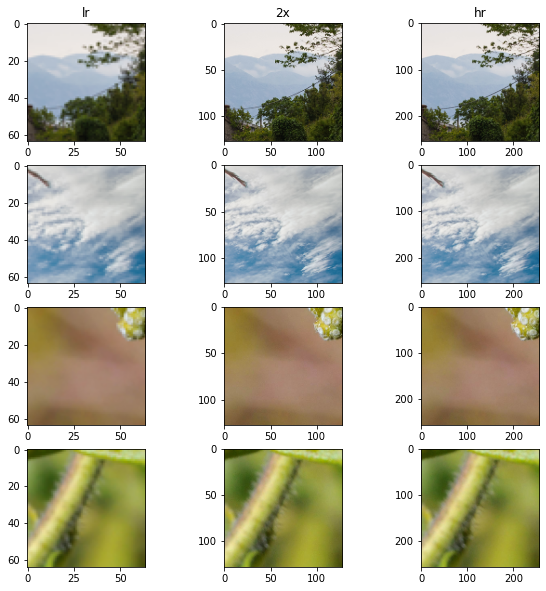

In [60]:
# Visualize Training Data
fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(10,10))

for i in range(4):
    image = next(iter(train_ds))
    ax[i][0].imshow(image[0][i].numpy().astype('float32'))
    ax[i][1].imshow(image[1]['2x'][i].numpy().astype('float32'))
    ax[i][2].imshow(image[1]['4x'][i].numpy().astype('float32'))

ax[0][0].set_title("lr")
ax[0][1].set_title("2x")
ax[0][2].set_title("hr")

print(image[0][i].numpy().shape, image[1]['2x'][i].numpy().shape, image[1]['4x'][i].numpy().shape)

# 2. Train Model

In [7]:
def lapsrn():
    """Return the espcn model"""
    def residual_network(x, d=3, name=None):
        # Convolution Layers Stacks
        for _ in range(d):
            x = layers.Conv2D(64, (3,3), padding="same", activation=tf.keras.layers.LeakyReLU(alpha=0.2))(x)
        # Upscale
        x = layers.Conv2DTranspose(64, (4,4), strides=(2,2), padding='same', activation=tf.keras.layers.LeakyReLU(alpha=0.2), name=name)(x)
        return x

    # Feature Extraction Network
    input_lr = tf.keras.Input(shape=(None, None, 3))
    feature_2x = residual_network(input_lr, d=3, name='feature_2x')
    feature_4x = residual_network(feature_2x, d=3, name='feature_4x')

    # Residual Image
    residual_2x = layers.Conv2D(3, (3,3), padding="same", activation=tf.keras.layers.LeakyReLU(alpha=0.2), name='residual_2x')(feature_2x)
    residual_4x = layers.Conv2D(3, (3,3), padding="same", activation=tf.keras.layers.LeakyReLU(alpha=0.2), name='residual_4x')(feature_4x)
    
    # Reconstruction Network
    upscale_2x = layers.Conv2DTranspose(3, (4,4), strides=(2,2), padding='same')(input_lr)
    reconstruction_2x = layers.Add(name='reconstruction_2x')([upscale_2x, residual_2x])
    upscale_4x = layers.Conv2DTranspose(3, (4,4), strides=(2,2), padding='same')(reconstruction_2x)
    reconstruction_4x = layers.Add(name='reconstruction_4x')([upscale_4x, residual_4x])

    model = models.Model(inputs=input_lr, outputs={'2x': reconstruction_2x, '4x': reconstruction_4x})
    return model

def psnr(y_true, y_pred):
    max_pixel = 1.0
    return 10 * (tf.math.log(max_pixel ** 2) - tf.math.log(tf.reduce_mean(tf.math.square(y_true - y_pred)))) / tf.math.log(10.0)
    

# A wrapper function is required to pass additional arguments to custom loss functions, because keras only allows 2 arguments, y_true and y_pred.
def charbonnier(epsilon=0.001):
    def loss(y_true, y_pred):
        return tf.reduce_mean(tf.math.sqrt(tf.math.square(y_true-y_pred) + tf.math.square(epsilon)))
    return loss

In [10]:
model = lapsrn()
model.summary()
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.0001),
              loss={'2x': charbonnier(epsilon=0.001), '4x': charbonnier(epsilon=0.001)},
              loss_weights={'2x': 1, '4x': 1},
              metrics={'2x': [psnr], '4x': [psnr]})
# Save model architecture as image
_ = tf.keras.utils.plot_model(model, to_file=os.path.join(model_dir, 'LapSRN.png'), show_shapes=True)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d_6 (Conv2D)              (None, None, None,   1792        ['input_2[0][0]']                
                                64)                                                               
                                                                                                  
 conv2d_7 (Conv2D)              (None, None, None,   36928       ['conv2d_6[0][0]']               
                                64)                                                         

In [11]:
# earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(train_ds, validation_data=val_ds, epochs=20, verbose=1, batch_size=batch_size)

Epoch 1/20


2022-01-01 19:51:19.132098: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


   1961/Unknown - 2101s 1s/step - loss: 0.1217 - reconstruction_2x_loss: 0.0568 - reconstruction_4x_loss: 0.0649 - reconstruction_2x_psnr: 21.3259 - reconstruction_4x_psnr: 20.7149

2022-01-01 20:26:19.883564: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


1961/1961 [==============================] - 2253s 1s/step - loss: 0.1217 - reconstruction_2x_loss: 0.0568 - reconstruction_4x_loss: 0.0649 - reconstruction_2x_psnr: 21.3259 - reconstruction_4x_psnr: 20.7149 - val_loss: 0.0806 - val_reconstruction_2x_loss: 0.0372 - val_reconstruction_4x_loss: 0.0433 - val_reconstruction_2x_psnr: 24.3755 - val_reconstruction_4x_psnr: 23.4914
Epoch 2/20
1961/1961 [==============================] - 2231s 1s/step - loss: 0.0757 - reconstruction_2x_loss: 0.0349 - reconstruction_4x_loss: 0.0408 - reconstruction_2x_psnr: 25.4871 - reconstruction_4x_psnr: 24.4111 - val_loss: 0.0694 - val_reconstruction_2x_loss: 0.0320 - val_reconstruction_4x_loss: 0.0374 - val_reconstruction_2x_psnr: 26.3034 - val_reconstruction_4x_psnr: 25.2492
Epoch 3/20
1961/1961 [==============================] - 2232s 1s/step - loss: 0.0684 - reconstruction_2x_loss: 0.0315 - reconstruction_4x_loss: 0.0369 - reconstruction_2x_psnr: 26.4723 - reconstruction_4x_psnr: 25.3954 - val_loss: 0.06

In [12]:
# Save model
# model.save_weights(os.path.join(model_dir, 'lapsrn_x4_charbonnier_2_output.h5'))

[]

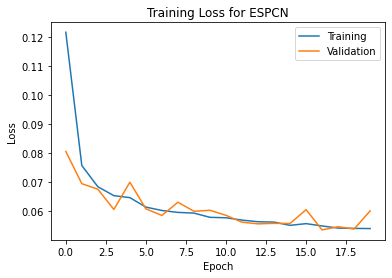

In [40]:
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(history.history['loss'], label='Training')
ax.plot(history.history['val_loss'], label='Validation')
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.set_title("Training Loss for ESPCN")
ax.legend()
ax.plot()

# 3. Evaluation

In [14]:
model.load_weights(os.path.join(model_dir, 'lapsrn_x4_charbonnier_2_output.h5'))

Because we are going to evaluate on images with different sizes, we cannot load them as a dataset like the training and validation dataset above.  
We need to load the images to numpy arrays ourselves, and then predict them one by one.  

Some datasets only provide HR images, so we need to downscale it ourselves.  
Also, an upscale function is implemented for upscaling LR images with bicubic interpolation for comparison.

In [15]:
def rescale(image, scale, downscale=False):
    image = tf.keras.preprocessing.image.array_to_img(image * 255)
    if downscale:
        image = utils.downscale_image(image, scale)
    else:
        image = utils.upscale_image(image, scale)
    image = tf.keras.preprocessing.image.img_to_array(image)
    return image / 255

### Validation Set

In [16]:
# Load the DIV2K validation dataset
val_hr_dir = 'data/DIV2K/validation/HR'
# val_lr_dir = 'data/DIV2K/validation/LRx4_unknown' # This is more difficult than bicubic downgrade
val_hr_images = utils.image_array_from_directory(val_hr_dir, downscale_factor=upscale_factor, limit=5)
val_lr_images = utils.image_array_from_directory(val_hr_dir, downscale_factor=upscale_factor, downscale=True, limit=5)

# Bicubic interpolation for comparison
bicubic_val_2x_images = []
bicubic_val_4x_images = []
for image in val_lr_images:
    bicubic_val_2x_images.append(rescale(image, 2))
    bicubic_val_4x_images.append(rescale(image, 4))
    
# Downscale HR image to 2x LR size for evaluating 2x output from the model
val_2x_images = []
for image in val_hr_images:
    val_2x_images.append(rescale(image, upscale_factor // 2, downscale=True))
    

5 images loaded from data/DIV2K/validation/HR.
5 images downscaled by a factor of 4 from data/DIV2K/validation/HR.


In [17]:
# Make predictions on Set5
predictions_2x = []
predictions_4x = []
for image in val_lr_images:
    hr_2x = model.predict(np.expand_dims(image, axis=0))['2x'][0]
    hr_2x = tf.clip_by_value(hr_2x, 0, 1)
    predictions_2x.append(hr_2x)
    hr_4x = model.predict(np.expand_dims(image, axis=0))['4x'][0]
    hr_4x = tf.clip_by_value(hr_4x, 0, 1)
    predictions_4x.append(hr_4x)

psnr_bicubic_2x = []
psnr_lapsrn_2x = []
for i in range(len(predictions_2x)):
    psnr_bicubic_2x.append(tf.image.psnr(bicubic_val_2x_images[i], val_2x_images[i], 1.0).numpy())
    psnr_lapsrn_2x.append(tf.image.psnr(predictions_2x[i], val_2x_images[i], 1.0).numpy())
psnr_bicubic_2x = np.array(psnr_bicubic_2x)
psnr_lapsrn_2x = np.array(psnr_lapsrn_2x)

print("PSNR (Bicubic 2x):", np.average(psnr_bicubic_2x), psnr_bicubic_2x)
print("PSNR (LapSRN 2x):", np.average(psnr_lapsrn_2x), psnr_lapsrn_2x)

psnr_bicubic_4x = []
psnr_lapsrn_4x = []
for i in range(len(predictions_4x)):
    psnr_bicubic_4x.append(tf.image.psnr(bicubic_val_4x_images[i], val_hr_images[i], 1.0).numpy())
    psnr_lapsrn_4x.append(tf.image.psnr(predictions_4x[i], val_hr_images[i], 1.0).numpy())
psnr_bicubic_4x = np.array(psnr_bicubic_4x)
psnr_lapsrn_4x = np.array(psnr_lapsrn_4x)

print("PSNR (Bicubic 4x):", np.average(psnr_bicubic_4x), psnr_bicubic_4x)
print("PSNR (LapSRN 4x):", np.average(psnr_lapsrn_4x), psnr_lapsrn_4x)

2022-01-02 07:41:03.257848: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-02 07:41:06.541963: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-02 07:41:08.401921: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


PSNR (Bicubic 2x): 31.76293 [29.802746 34.96752  35.461227 28.205702 30.377462]
PSNR (LapSRN 2x): 32.032787 [30.743792 31.897547 37.269596 29.383062 30.869942]
PSNR (Bicubic 4x): 28.847467 [27.628843 30.096975 33.603733 25.399736 27.508045]
PSNR (LapSRN 4x): 29.288752 [27.491724 32.660522 33.799793 25.590412 26.90131 ]


Text(0, 0.5, '4x')

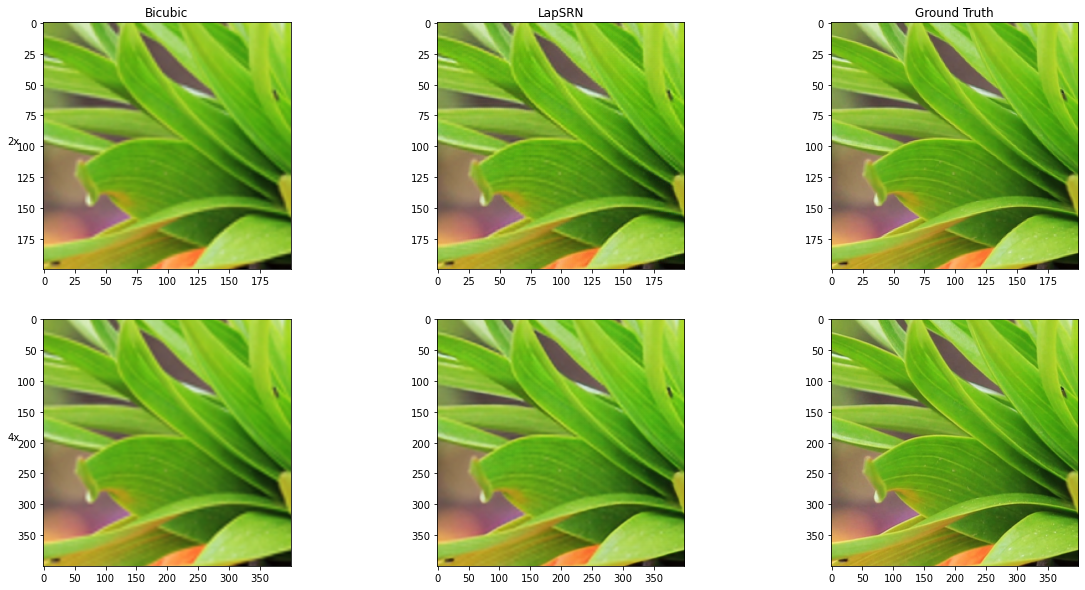

In [18]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))

idx = 2
plot_size = 200
x = np.random.randint(0, val_2x_images[i].shape[0]-plot_size)
y = np.random.randint(0, val_2x_images[i].shape[1]-plot_size)

ax[0][0].imshow(bicubic_val_2x_images[idx][x:x+plot_size, y:y+plot_size,:])
ax[0][1].imshow(predictions_2x[idx][x:x+plot_size, y:y+plot_size,:])
ax[0][2].imshow(val_2x_images[idx][x:x+plot_size, y:y+plot_size,:])

ax[1][0].imshow(bicubic_val_4x_images[idx][x*2:x*2+plot_size*2, y*2:y*2+plot_size*2,:])
ax[1][1].imshow(predictions_4x[idx][x*2:x*2+plot_size*2, y*2:y*2+plot_size*2,:])
ax[1][2].imshow(val_hr_images[idx][x*2:x*2+plot_size*2, y*2:y*2+plot_size*2,:])

ax[0][0].set_title("Bicubic")
ax[0][1].set_title("LapSRN")
ax[0][2].set_title("Ground Truth")

ax[0][0].set_ylabel("2x", rotation=0)
ax[1][0].set_ylabel("4x", rotation=0)

### Set5

In [19]:
# Load the Set5 dataset
set5_hr_dir = 'data/Set5'
set5_hr_images = utils.image_array_from_directory(set5_hr_dir, downscale_factor=upscale_factor)
set5_lr_images = utils.image_array_from_directory(set5_hr_dir, downscale_factor=upscale_factor, downscale=True)

# Bicubic interpolation for comparison
bicubic_set5_2x_images = []
bicubic_set5_4x_images = []
for image in set5_lr_images:
    bicubic_set5_2x_images.append(rescale(image, 2))
    bicubic_set5_4x_images.append(rescale(image, 4))

# Downscale HR image to 2x LR size for evaluating 2x output from the model
set5_2x_images = []
for image in set5_hr_images:
    set5_2x_images.append(rescale(image, upscale_factor // 2, downscale=True))

5 images loaded from data/Set5.
5 images downscaled by a factor of 4 from data/Set5.


In [41]:
# Make predictions on Set5
predictions_2x = []
predictions_4x = []
for image in set5_lr_images:
    hr_2x = model.predict(np.expand_dims(image, axis=0))['2x'][0]
    hr_2x = tf.clip_by_value(hr_2x, 0, 1)
    predictions_2x.append(hr_2x)
    hr_4x = model.predict(np.expand_dims(image, axis=0))['4x'][0]
    hr_4x = tf.clip_by_value(hr_4x, 0, 1)
    predictions_4x.append(hr_4x)

psnr_bicubic_2x = []
psnr_lapsrn_2x = []
for i in range(len(predictions_2x)):
    psnr_bicubic_2x.append(tf.image.psnr(bicubic_set5_2x_images[i], set5_2x_images[i], 1.0).numpy())
    psnr_lapsrn_2x.append(tf.image.psnr(predictions_2x[i], set5_2x_images[i], 1.0).numpy())
psnr_bicubic_2x = np.array(psnr_bicubic_2x)
psnr_lapsrn_2x = np.array(psnr_lapsrn_2x)

print("PSNR (Bicubic 2x):", np.average(psnr_bicubic_2x), psnr_bicubic_2x)
print("PSNR (LapSRN 2x):", np.average(psnr_lapsrn_2x), psnr_lapsrn_2x)

psnr_bicubic_4x = []
psnr_lapsrn_4x = []
for i in range(len(predictions_4x)):
    psnr_bicubic_4x.append(tf.image.psnr(bicubic_set5_4x_images[i], set5_hr_images[i], 1.0).numpy())
    psnr_lapsrn_4x.append(tf.image.psnr(predictions_4x[i], set5_hr_images[i], 1.0).numpy())
psnr_bicubic_4x = np.array(psnr_bicubic_4x)
psnr_lapsrn_4x = np.array(psnr_lapsrn_4x)

print("PSNR (Bicubic 4x):", np.average(psnr_bicubic_4x), psnr_bicubic_4x)
print("PSNR (LapSRN 4x):", np.average(psnr_lapsrn_4x), psnr_lapsrn_4x)

PSNR (Bicubic 2x): 28.82249 [32.72212  29.83145  22.347332 31.999847 27.211712]
PSNR (LapSRN 2x): 30.79158 [33.70705  31.671198 26.190874 32.948708 29.440071]
PSNR (Bicubic 4x): 26.59675 [30.416115 28.068218 20.456728 28.963413 25.079266]
PSNR (LapSRN 4x): 27.53919 [29.429312 29.662605 23.418629 28.826542 26.358873]


Text(0, 0.5, '4x')

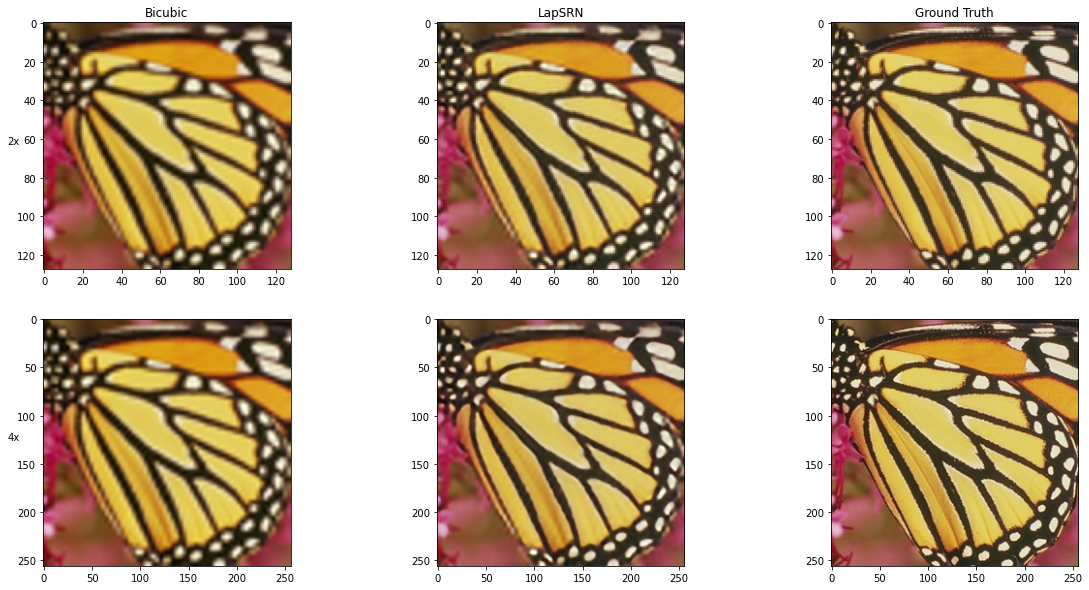

In [45]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))

idx = 2
ax[0][0].imshow(bicubic_set5_2x_images[idx])
ax[0][1].imshow(predictions_2x[idx])
ax[0][2].imshow(set5_2x_images[idx])

ax[1][0].imshow(bicubic_set5_4x_images[idx])
ax[1][1].imshow(predictions_4x[idx])
ax[1][2].imshow(set5_hr_images[idx])

ax[0][0].set_title("Bicubic")
ax[0][1].set_title("LapSRN")
ax[0][2].set_title("Ground Truth")

ax[0][0].set_ylabel("2x", rotation=0)
ax[1][0].set_ylabel("4x", rotation=0)

### Set14

In [22]:
# Load the Set14 dataset
set14_hr_dir = 'data/Set14'
set14_hr_images = utils.image_array_from_directory(set14_hr_dir, downscale_factor=upscale_factor)
set14_lr_images = utils.image_array_from_directory(set14_hr_dir, downscale_factor=upscale_factor, downscale=True)

# Bicubic interpolation for comparison
bicubic_set14_2x_images = []
bicubic_set14_4x_images = []
for image in set14_lr_images:
    bicubic_set14_2x_images.append(rescale(image, 2))
    bicubic_set14_4x_images.append(rescale(image, 4))

# Downscale HR image to 2x LR size for evaluating 2x output from the model
set14_2x_images = []
for image in set14_hr_images:
    set14_2x_images.append(rescale(image, upscale_factor // 2, downscale=True))

14 images loaded from data/Set14.
14 images downscaled by a factor of 4 from data/Set14.


In [23]:
# Make predictions on Set5
predictions_2x = []
predictions_4x = []
for image in set14_lr_images:
    hr_2x = model.predict(np.expand_dims(image, axis=0))['2x'][0]
    hr_2x = tf.clip_by_value(hr_2x, 0, 1)
    predictions_2x.append(hr_2x)
    hr_4x = model.predict(np.expand_dims(image, axis=0))['4x'][0]
    hr_4x = tf.clip_by_value(hr_4x, 0, 1)
    predictions_4x.append(hr_4x)

psnr_bicubic_2x = []
psnr_lapsrn_2x = []
for i in range(len(predictions_2x)):
    psnr_bicubic_2x.append(tf.image.psnr(bicubic_set14_2x_images[i], set14_2x_images[i], 1.0).numpy())
    psnr_lapsrn_2x.append(tf.image.psnr(predictions_2x[i], set14_2x_images[i], 1.0).numpy())
psnr_bicubic_2x = np.array(psnr_bicubic_2x)
psnr_lapsrn_2x = np.array(psnr_lapsrn_2x)

print("PSNR (Bicubic 2x):", np.average(psnr_bicubic_2x), psnr_bicubic_2x)
print("PSNR (LapSRN 2x):", np.average(psnr_lapsrn_2x), psnr_lapsrn_2x)

psnr_bicubic_4x = []
psnr_lapsrn_4x = []
for i in range(len(predictions_4x)):
    psnr_bicubic_4x.append(tf.image.psnr(bicubic_set14_4x_images[i], set14_hr_images[i], 1.0).numpy())
    psnr_lapsrn_4x.append(tf.image.psnr(predictions_4x[i], set14_hr_images[i], 1.0).numpy())
psnr_bicubic_4x = np.array(psnr_bicubic_4x)
psnr_lapsrn_4x = np.array(psnr_lapsrn_4x)

print("PSNR (Bicubic 4x):", np.average(psnr_bicubic_4x), psnr_bicubic_4x)
print("PSNR (LapSRN 4x):", np.average(psnr_lapsrn_4x), psnr_lapsrn_4x)

PSNR (Bicubic 2x): 26.85588 [24.635069 27.503008 26.658165 27.406118 23.343798 32.475876 26.550566
 26.705072 30.231108 24.788246 27.035982 30.378551 23.236855 25.033947]
PSNR (LapSRN 2x): 28.063618 [24.926414 28.828922 27.693777 28.160946 24.482187 32.940052 28.03617
 30.216787 28.213778 29.520706 30.87292  26.520082 25.152765 27.325136]
PSNR (Bicubic 4x): 23.864874 [20.251326 23.492079 23.058163 23.99146  20.705992 28.893435 24.017973
 24.908741 27.736486 22.748953 25.3633   24.942438 20.758593 23.239292]
PSNR (LapSRN 4x): 25.01447 [20.418642 23.859459 23.334696 24.19737  21.357796 28.79607  25.026596
 26.566166 28.330858 25.175463 28.013372 27.755272 22.23879  25.132034]


Text(0, 0.5, '4x')

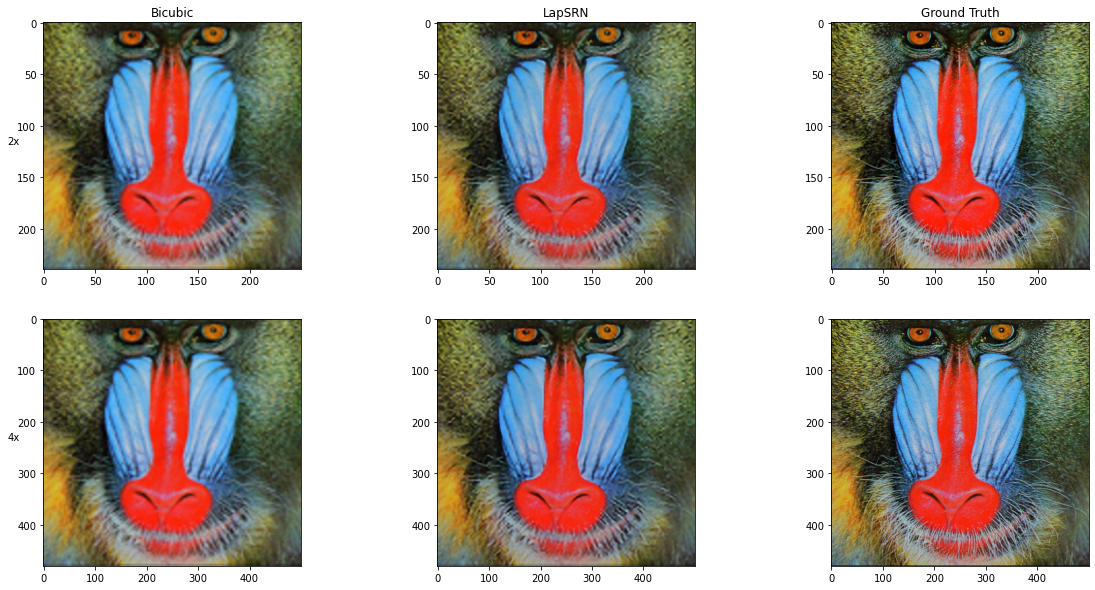

In [24]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))

idx = 0
ax[0][0].imshow(bicubic_set14_2x_images[idx])
ax[0][1].imshow(predictions_2x[idx])
ax[0][2].imshow(set14_2x_images[idx])

ax[1][0].imshow(bicubic_set14_4x_images[idx])
ax[1][1].imshow(predictions_4x[idx])
ax[1][2].imshow(set14_hr_images[idx])

ax[0][0].set_title("Bicubic")
ax[0][1].set_title("LapSRN")
ax[0][2].set_title("Ground Truth")

ax[0][0].set_ylabel("2x", rotation=0)
ax[1][0].set_ylabel("4x", rotation=0)

## Visualizing Layer Outputs

In [25]:
from keras import backend as K

In [26]:
input_image = set5_lr_images[2]

outputs = {}
for layer in model.layers:
    print(layer.name)
    keras_function = K.function([model.input], [layer.output])
    outputs[layer.name] = keras_function([np.expand_dims(input_image, axis=0)])

input_2
conv2d_6
conv2d_7
conv2d_8
feature_2x
conv2d_9
conv2d_10
conv2d_transpose_2
residual_2x
conv2d_11
reconstruction_2x
feature_4x
conv2d_transpose_3
residual_4x
reconstruction_4x


Input image: (64, 64, 3)


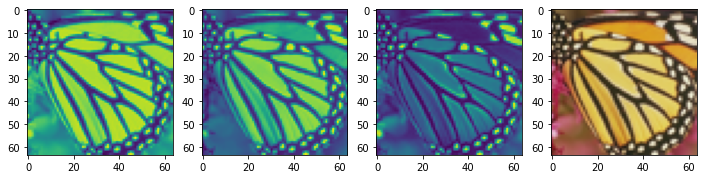

In [27]:
print("Input image:", input_image.shape)

fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(12,4))
for i in range(3):
    ax[i].imshow(input_image[:,:,i])
ax[3].imshow(input_image)

2x Features: (128, 128, 64)


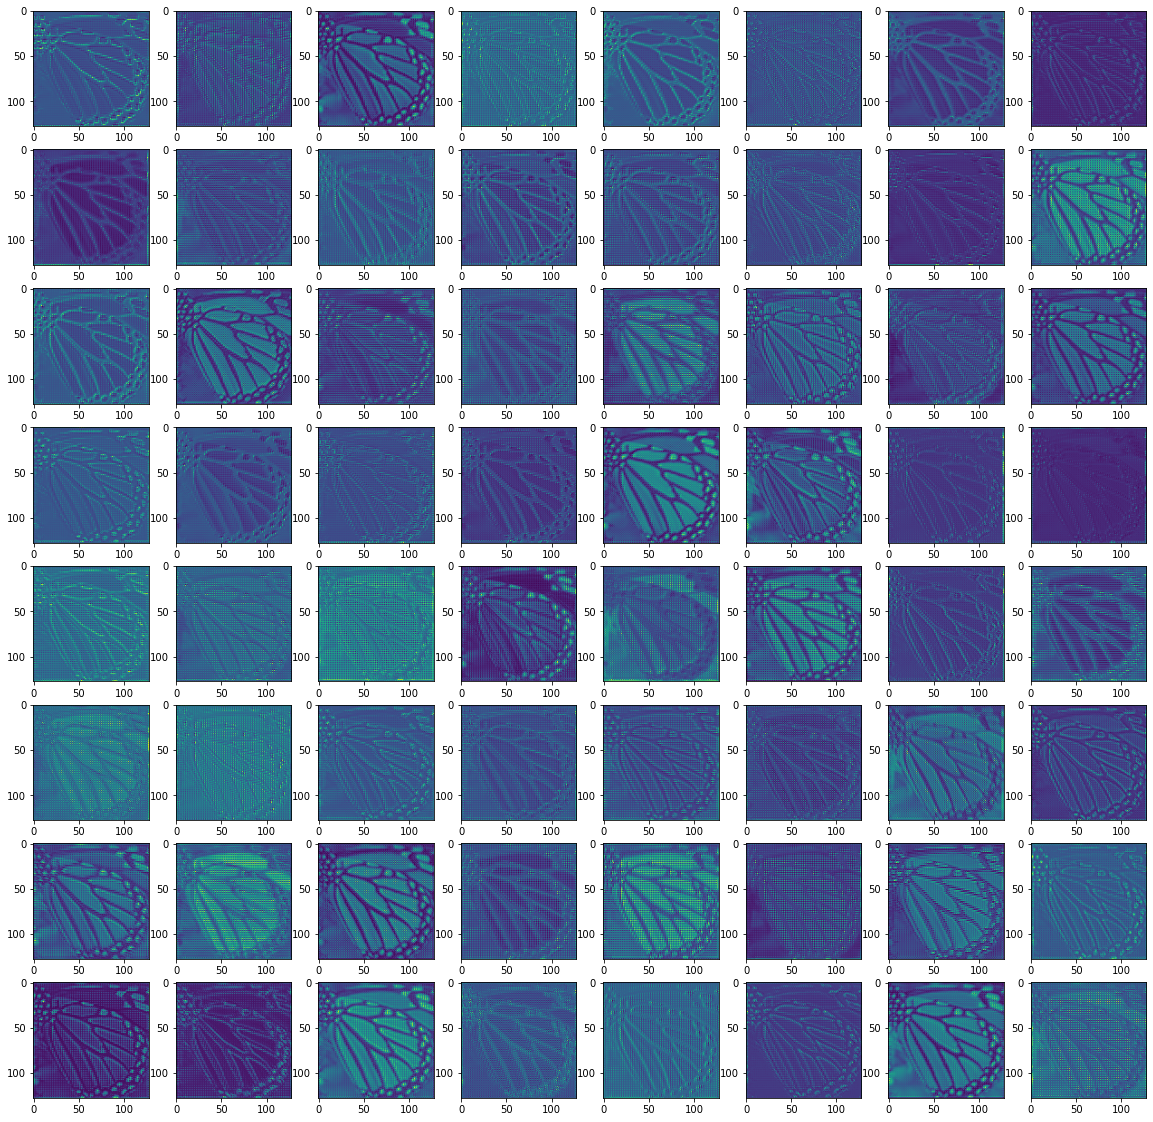

In [28]:
features_2x = np.array(outputs['feature_2x'][0][0])
print("2x Features:", features_2x.shape)

fig, ax = plt.subplots(nrows=8, ncols=8, figsize=(20,20))
for i in range(features_2x.shape[-1]):
    ax[i//8][i%8].imshow(features_2x[:,:,i])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2x Residual: (128, 128, 3)


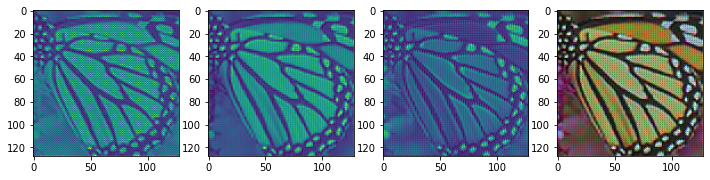

In [29]:
residual_2x = np.array(outputs['residual_2x'][0][0])
print("2x Residual:", residual_2x.shape)

fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(12,4))
for i in range(3):
    ax[i].imshow(residual_2x[:,:,i])
ax[3].imshow(residual_2x)

2x Output: (128, 128, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


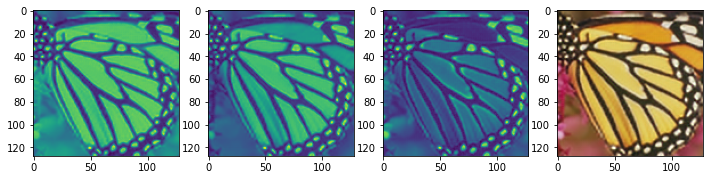

In [30]:
reconstruct_2x = np.array(outputs['reconstruction_2x'][0][0])
print("2x Output:", reconstruct_2x.shape)

fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(12,4))
for i in range(3):
    ax[i].imshow(reconstruct_2x[:,:,i])
ax[3].imshow(reconstruct_2x)

4x Features: (256, 256, 64)


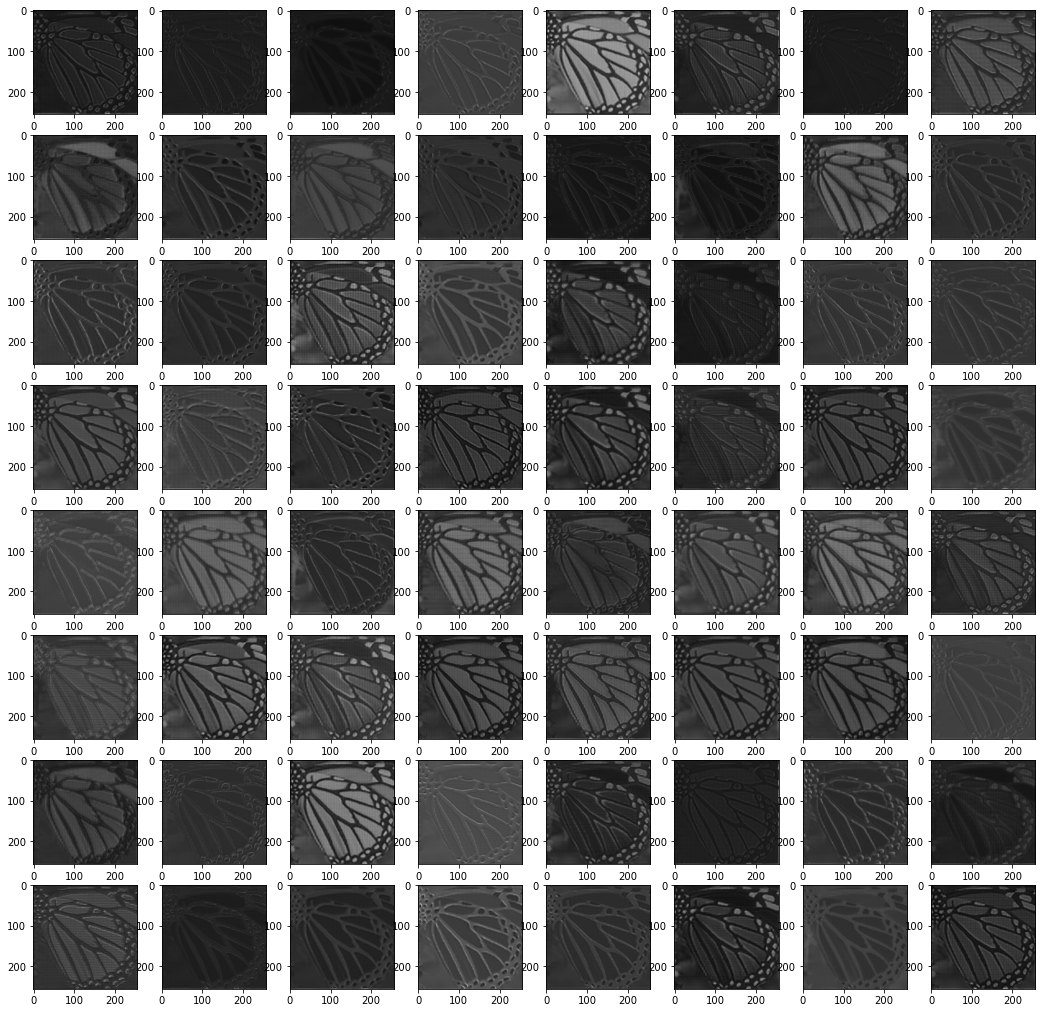

In [36]:
features_4x = np.array(outputs['feature_4x'][0][0])
print("4x Features:", features_4x.shape)

fig, ax = plt.subplots(nrows=8, ncols=8, figsize=(18,18))
for i in range(features_4x.shape[-1]):
    ax[i//8][i%8].imshow(features_4x[:,:,i], cmap='gray')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4x Residual: (256, 256, 3)


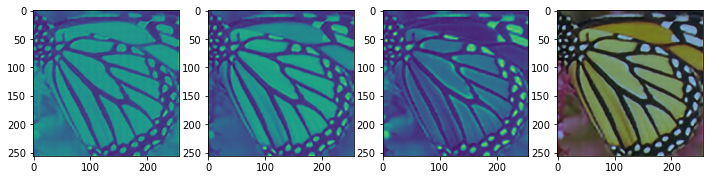

In [32]:
residual_4x = np.array(outputs['residual_4x'][0][0])
print("4x Residual:", residual_4x.shape)

fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(12,4))
for i in range(3):
    ax[i].imshow(residual_4x[:,:,i])
ax[3].imshow(residual_4x)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4x Output: (256, 256, 3)


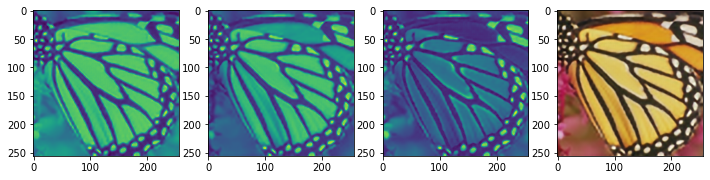

In [33]:
reconstruct_4x = np.array(outputs['reconstruction_4x'][0][0])
print("4x Output:", reconstruct_4x.shape)

fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(12,4))
for i in range(3):
    ax[i].imshow(reconstruct_4x[:,:,i])
ax[3].imshow(reconstruct_4x)